### 할당된 GPU 확인

In [1]:
!nvidia-smi

Tue Jun 15 04:48:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

### 필요한 library 및 자료 다운로드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
#!pip install kobert-transformers

     |████████████████████████████████| 46.9MB 119kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 8.1MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595698 sha256=4762aac698bc225a5e62f48366ec99cc3cb559c87c0259fc5c37ab4d1667511e
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 7.3MB/s 
     |████████████████████████████████| 2.3MB 8.1MB/s 
     |████████████████████████████████| 901kB 45.5MB/s 
     |████████████████████████████████| 3.3MB 49.8MB/s 


In [4]:
#!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [6]:
#from kobert.pytorch_kobert import get_pytorch_kobert_model

In [7]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [8]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [9]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()
model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [11]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/problem_ner_min_re_275_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber.csv'

In [12]:
df = pd.read_csv(file1)

In [13]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'id', 'title', 'description', 'input', 'output', 'text', 'ner_decode',
       'list_ner', 'ner_preprocessed_desc', 'Mathematics',
       'Dynamic_programming', 'Implementation', 'Graph_theory',
       'Data_structures', 'Greedy', 'String', 'Graph_traversal',
       'Bruteforcing', 'Tree', 'Binary_search', 'Number_theory',
       'Breadth_first_search', 'Depth_first_search', 'Dijkstras',
       'Divide_and_conquer', 'Stack', 'Priority_queue', 'only_korean_desc',
       'only_korean_input', 'only_korean_output', 'only_korean_variable_desc',
       'only_korean_variablenumber_desc', 'only_korean_variablenumber_input',
       'only_korean_variablenumber_output', 'variablenumber_desc',
       'variablenumber_input', 'variablenumber_output',
       'desc_variabel_renumber', 'input_variabel_renumber',
       'output_variabel_renumber', 'desc_variabel_renumber_0',
       'input_variabel_renumber_0', 'output_varia

In [14]:
target_name = ['Mathematics', 'Dynamic_programming', 'Implementation', 'Graph_theory',
       'Data_structures', 'Greedy', 'String', 'Graph_traversal',
       'Bruteforcing', 'Tree', 'Binary_search', 'Number_theory',
       'Breadth_first_search', 'Depth_first_search', 'Dijkstras',
       'Divide_and_conquer', 'Stack', 'Priority_queue']

In [15]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5)

### 분류한 dataset을 형식에 맞게 변환하는 코드

In [16]:
def set_data(df) :
  dataset = []
  for index, row in df.iterrows():
    problem = []
    desc = row['desc_variabel_renumber_0']
    if not pd.isna(row['input_variabel_renumber_0']) :
       desc = desc + row['input_variabel_renumber_0'] 
    problem.append(desc)
    for i in target_name :
      problem.append(row[i])
    dataset.append(problem)
  return dataset

In [17]:
dataset_train = set_data(train_df)
dataset_valid = set_data(valid_df)
dataset_test = set_data(test_df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [18]:
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)
#tokenizer = get_tokenizer()

### 데이터셋 관련 코드

In [19]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = np.array([i[label_idx:] for i in dataset], dtype=np.int32)

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [20]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
num_epochs = 8
max_grad_norm = 1
log_interval = 100
learning_rate =  1e-5

### 데이터 셋 표준화 과정

In [21]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [22]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [23]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size , num_classes)
        )
        if dr_rate : 
           self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

### model 할당

In [24]:
model = BERTClassifier(bertmodel, num_classes=18, dr_rate=0.1).to(device) 

In [25]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

### optimizer와 loss function 설정

In [26]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.MultiLabelSoftMarginLoss()

### 잘 모르겠음 ;;

In [27]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [28]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

### 정확도 계산하는 함수

In [29]:
threshold = 0.5

In [30]:
def calc_accuracy_multilabel(X,Y):
    N, C = Y.shape
    X[X >= threshold] = 1
    X[X < threshold] = 0
    train_acc = (X == Y).sum().data.cpu().numpy()/ (N * C)
    return train_acc

# train 시키는 코드

In [31]:
train_loss_values = []
validation_loss_values = [] 

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.float().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        out = torch.sigmoid(out)
        train_acc += calc_accuracy_multilabel(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        validation_loss += loss.item() 
        out = torch.sigmoid(out)
        test_acc += calc_accuracy_multilabel(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


epoch 1 batch id 1 loss 0.6823478937149048 train acc 0.6111111111111112
epoch 1 batch id 101 loss 0.5391368865966797 train acc 0.753850385038504
epoch 1 batch id 201 loss 0.4234267473220825 train acc 0.8292564953012718
epoch 1 batch id 301 loss 0.3190075755119324 train acc 0.8541435954226656

epoch 1 train acc 0.8631868548876745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.9066162681669013


epoch 2 batch id 1 loss 0.272154301404953 train acc 0.9236111111111112
epoch 2 batch id 101 loss 0.3269726634025574 train acc 0.9064218921892192
epoch 2 batch id 201 loss 0.30597639083862305 train acc 0.9059217799889442
epoch 2 batch id 301 loss 0.2538573741912842 train acc 0.9053386858619423

epoch 2 train acc 0.9052899210686097



epoch 2 test acc 0.9066162681669013


epoch 3 batch id 1 loss 0.23036515712738037 train acc 0.9236111111111112
epoch 3 batch id 101 loss 0.32109948992729187 train acc 0.9064218921892192
epoch 3 batch id 201 loss 0.28471899032592773 train acc 0.906025428413488
epoch 3 batch id 301 loss 0.24881093204021454 train acc 0.9054078995939466

epoch 3 train acc 0.9054606860959323



epoch 3 test acc 0.9066162681669013


epoch 4 batch id 1 loss 0.22473487257957458 train acc 0.9236111111111112
epoch 4 batch id 101 loss 0.3053632974624634 train acc 0.9080720572057213
epoch 4 batch id 201 loss 0.2873021960258484 train acc 0.9078220011055834
epoch 4 batch id 301 loss 0.2372966855764389 train acc 0.9073228128460685

epoch 4 train acc 0.9072062841530054



epoch 4 test acc 0.9092533989685893


epoch 5 batch id 1 loss 0.22552235424518585 train acc 0.9305555555555556
epoch 5 batch id 101 loss 0.30571067333221436 train acc 0.9104785478547859
epoch 5 batch id 201 loss 0.26252198219299316 train acc 0.9103095632946376
epoch 5 batch id 301 loss 0.23392094671726227 train acc 0.9096299372462159

epoch 5 train acc 0.9096349423193679



epoch 5 test acc 0.9102203469292081


epoch 6 batch id 1 loss 0.22385290265083313 train acc 0.9305555555555556
epoch 6 batch id 101 loss 0.2855556607246399 train acc 0.9117849284928498
epoch 6 batch id 201 loss 0.251867413520813 train acc 0.9122097844112768
epoch 6 batch id 301 loss 0.2285854071378708 train acc 0.911383351790328

epoch 6 train acc 0.9115702792956892



epoch 6 test acc 0.913003984997656


epoch 7 batch id 1 loss 0.220262348651886 train acc 0.9236111111111112
epoch 7 batch id 101 loss 0.28133684396743774 train acc 0.9135726072607264
epoch 7 batch id 201 loss 0.2446787804365158 train acc 0.9135572139303477
epoch 7 batch id 301 loss 0.22230692207813263 train acc 0.9129752676264298

epoch 7 train acc 0.9128908621736487



epoch 7 test acc 0.9130039849976563


epoch 8 batch id 1 loss 0.20309951901435852 train acc 0.9236111111111112
epoch 8 batch id 101 loss 0.2842065691947937 train acc 0.9143976897689774
epoch 8 batch id 201 loss 0.24580028653144836 train acc 0.9145245992260919
epoch 8 batch id 301 loss 0.23015829920768738 train acc 0.9135289774824653

epoch 8 train acc 0.9134107468123859



epoch 8 test acc 0.9121249413970938


### loss graph 그린다

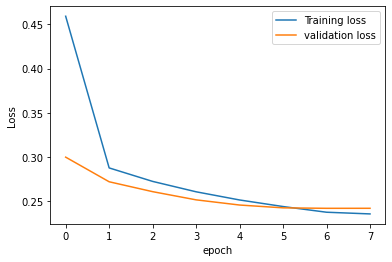

In [32]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### predict하는 코드

In [33]:
pred_list = []
test_label = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    test_label.extend(label)
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    out = torch.sigmoid(out)
    pred_list.extend(out.cpu().numpy())

pred_list = np.array([a.tolist() for a in pred_list])
test_label = np.array([a.squeeze().tolist() for a in test_label])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [43]:
thresholds = [0.4, 0.25, 0.26, 0.45, 0.25, 0.12, 0.25, 0.24, 0.1, 0.2, 0.08, 0.17, 0.14, 0.12, 0.08, 0.06, 0.02, 0.06]

In [44]:
acc = 0.0
for i in range(len(pred_list)) :
  sum = 0.0
  all = 0
  for j in range(18) :
    if pred_list[i][j] >= thresholds[j] :
      tmp = 1
    else :
      tmp = 0
    if tmp == 1 or test_label[i][j] == 1 :
      all += 1
    if test_label[i][j] == 1 and tmp == test_label[i][j] :
      sum += 1
  acc += sum / all
acc /= len(pred_list)
print('test acc : {}' .format(acc))

test acc : 0.1935244934048762


In [34]:
from matplotlib import pyplot as plt 

target_name = ['Mathematics',	'Dynamic_programming',	'Implementation',	'Graph_theory',	'Data_structures',	'Greedy',	'String',	
       'Graph_traversal',	'Bruteforcing',	'Tree',	'Binary_search',	'Number_theory',	'Breadth_first_search',	
       'Depth_first_search',	'Dijkstras',	'Divide_and_conquer',	'Stack',	'Priority_queue']

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, length):
    plt.plot(thresholds, precisions[:length], "b--", label='precision')
    plt.plot(thresholds, recalls[:length], "g-", label='recall')
    plt.xlabel("threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

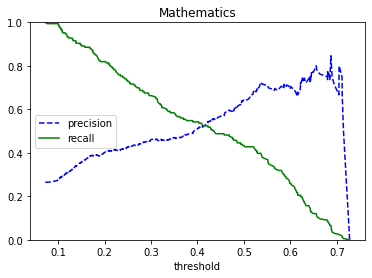

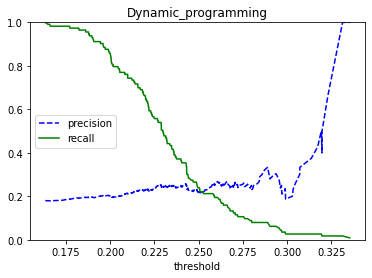

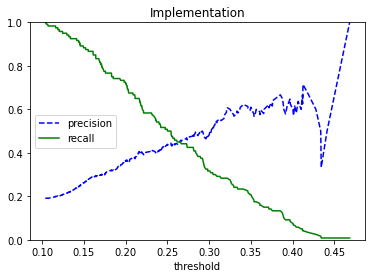

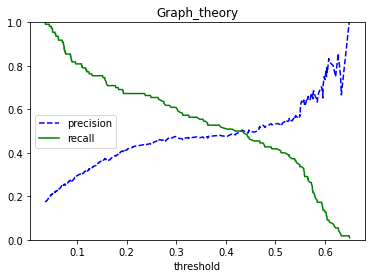

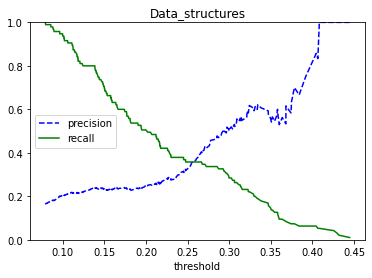

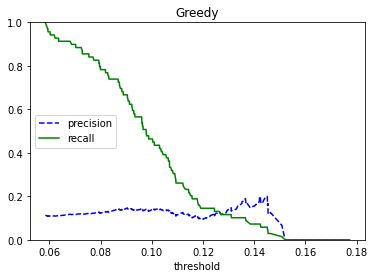

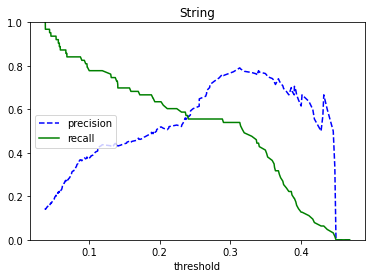

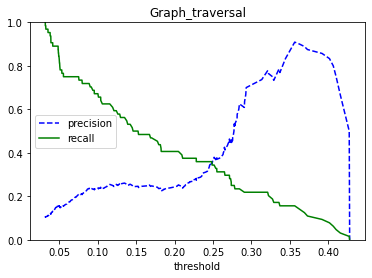

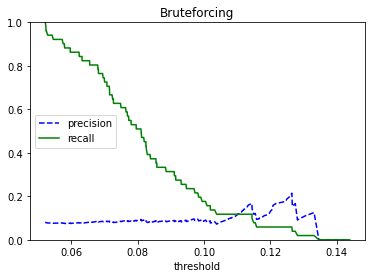

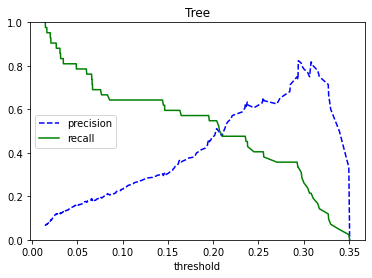

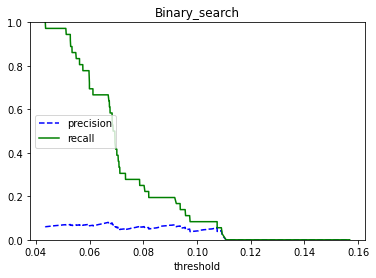

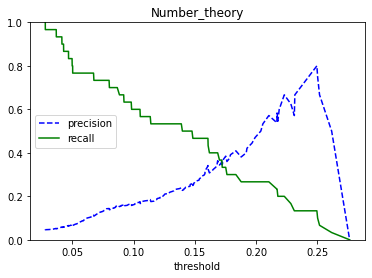

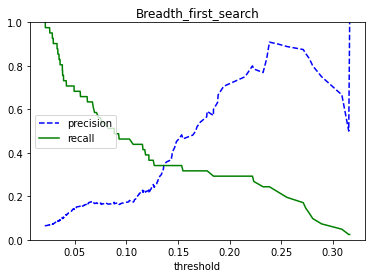

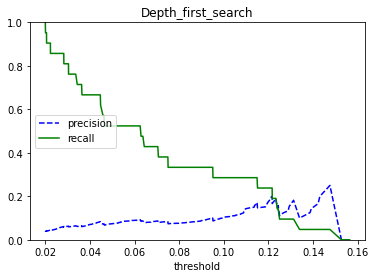

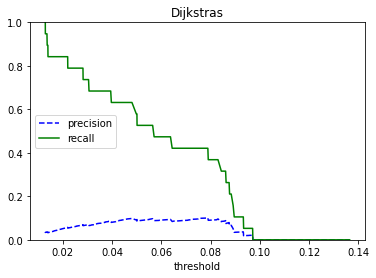

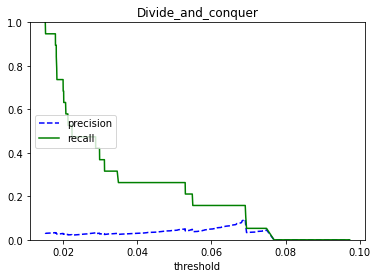

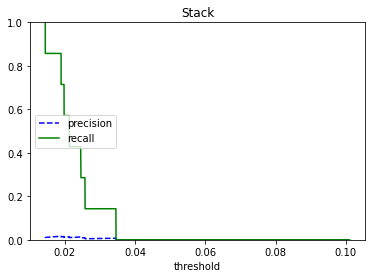

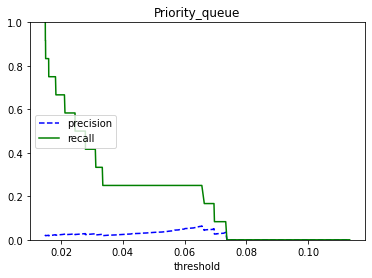

In [35]:
from sklearn.metrics import precision_recall_curve

for i in range(18) :
  y_scores = pred_list[:,i]
  y_true = test_label[:,i]
  precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
  plot_precision_recall_vs_threshold(precision, recall, thresholds, len(thresholds))
  plt.title(target_name[i])
  plt.savefig('/content/drive/MyDrive/single_tuning/' + target_name[i] + '2.png')
  plt.show()

In [36]:
def draw_PR_graph(test_label, pred_list, i) :
  precision, recall, _ = precision_recall_curve(test_label, pred_list)

  ap = average_precision_score(test_label, pred_list)

  plt.title(target_name[i])
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  plt.plot(recall, precision, 'b', label = 'Classifier (AP = %0.2F)'%ap)   

  plt.legend(loc='upper right')
  plt.show()

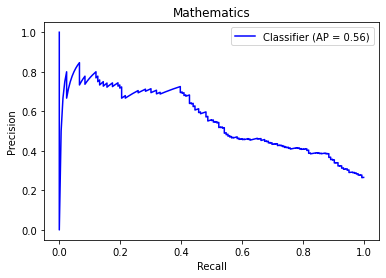

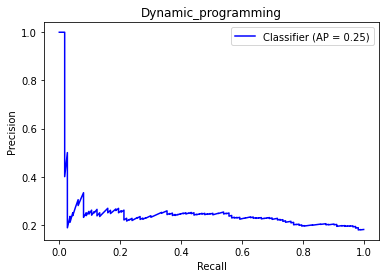

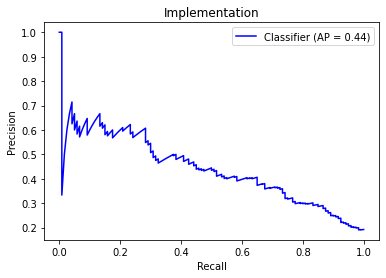

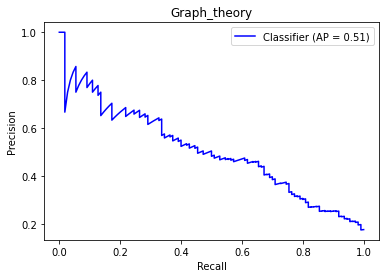

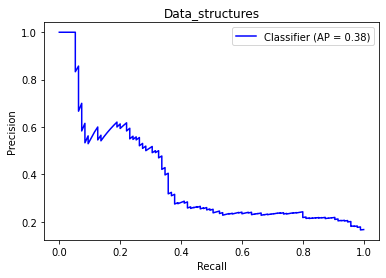

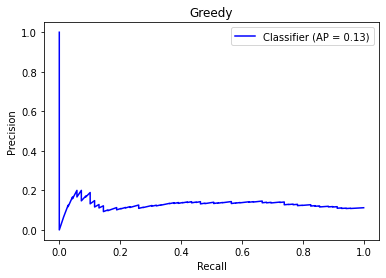

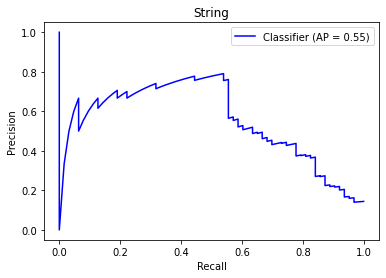

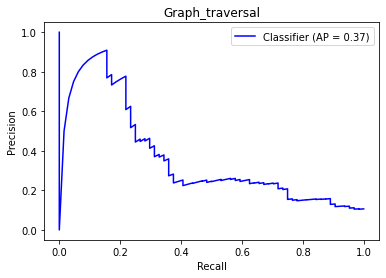

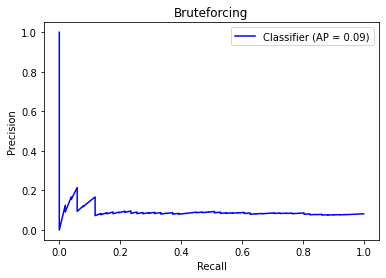

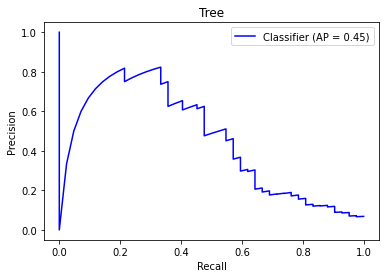

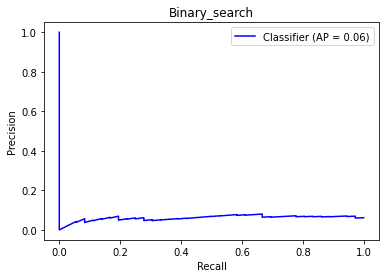

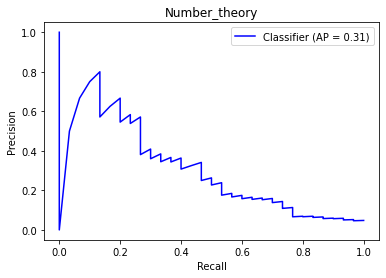

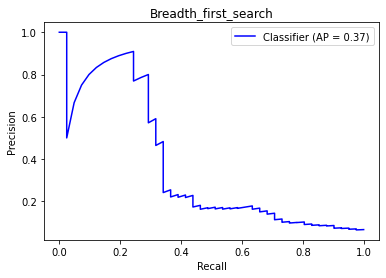

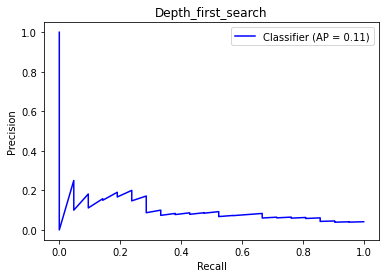

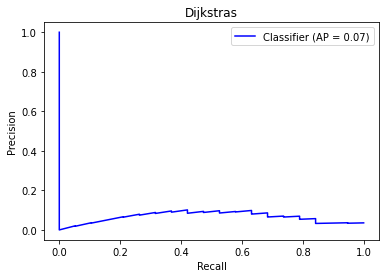

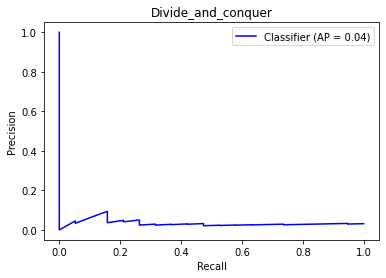

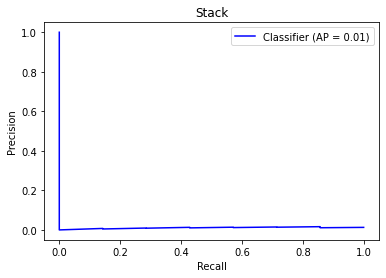

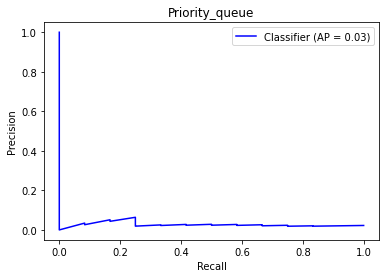

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

for i in range(18) :
  y_scores = pred_list[:,i]
  y_true = test_label[:,i]
  draw_PR_graph(y_true, y_scores, i)

### test data에서 맞은 지문과 틀린 지문을 나누어 저장하기 위한 코드

In [38]:
"""
pl = encoder.inverse_transform(pred_list)

false_df = extract_false(test_df, pl)
true_df = extract_true(test_df, pl)
false_df.to_csv('/content/drive/MyDrive/false_prediction_120.csv', encoding='utf-8-sig')
true_df.to_csv('/content/drive/MyDrive/true_prediction_120.csv', encoding='utf-8-sig')
"""

"\npl = encoder.inverse_transform(pred_list)\n\nfalse_df = extract_false(test_df, pl)\ntrue_df = extract_true(test_df, pl)\nfalse_df.to_csv('/content/drive/MyDrive/false_prediction_120.csv', encoding='utf-8-sig')\ntrue_df.to_csv('/content/drive/MyDrive/true_prediction_120.csv', encoding='utf-8-sig')\n"

### y축 = input x축 = 예측 결과, 대각선의 확률이 a일 때 a로 예측한 확률

In [39]:
"""
cm = confusion_matrix(test_label, pred_list)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(11, 11))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
"""

"\ncm = confusion_matrix(test_label, pred_list)\ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]\ndf_cm = pd.DataFrame(cm, target_name, target_name)\nplt.figure(figsize=(11, 11))\nplt.title('confusion matrix with normalized')\nsn.heatmap(df_cm, annot = True)\n\nplt.ylabel('True label')\nplt.xlabel('Predicted label')\nplt.show()\n"

### 학습한 모델 저장하기 위한 코드

In [40]:
import os

save_dir = '/content/drive/MyDrive/model_save/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#save_name = save_dir + 'bert.pt'
save_name = save_dir + 'aug_bert.pt'

def save(model, optimizer, file):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, file)


In [41]:
#save(model, optimizer, save_name)

### load model

In [42]:
"""
checkpoint = torch.load(save_name, map_location='cpu')

model2 = BERTClassifier(bertmodel, num_classes=11, dr_rate=0.2).to(device)
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
"""

"\ncheckpoint = torch.load(save_name, map_location='cpu')\n\nmodel2 = BERTClassifier(bertmodel, num_classes=11, dr_rate=0.2).to(device)\nmodel2.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\n"